Pistes à explorer: Remplacer output True par sections, e.g. <0, >0, >1, >5, >10

Preprocessing for classifier

In [14]:
import utils.helper_functions as hf
import pandas as pd

db_file_path = './db/ohlcv_ntickers_1254_2000-08-01_to_2023-12-23.pkl'

start_date = '2013-01-01'
target_net_profit = 0.05 #0.01 for 1%
n_future_days = 20
fee = 0.002
fee_factor = (1 - fee) / (1 + fee)

In [15]:
df = pd.read_pickle(db_file_path)
df = df[['Open']]
df = hf.remove_top_column_name(df)
df = hf.get_rows_after_date(df, start_date)

df.tail(5)

,1CALL.MI,2020.OL,5PG.OL,A2A.MI,A3M.MC,AAK.ST,AALB.AS,AB.PA,ABB.ST,ABCA.PA,...,XXL.OL,YAR.OL,YEXR.MC,YIPS.MC,YIV.MI,ZAL.OL,ZAP.OL,ZEAL.CO,ZENA.OL,ZV.MI
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-24 00:00:00,NaN,97.000000,2.080,1.6820,3.560,201.800003,38.959999,3.980,418.899994,5.86,...,1.750,402.700012,0.65,1.3,0.0220,42.0,29.320000,238.000000,0.0588,15.36
2023-07-25 00:00:00,NaN,98.750000,2.090,1.7095,3.600,201.399994,39.450001,4.190,420.399994,5.95,...,1.710,406.700012,0.65,1.3,0.0216,42.0,29.299999,231.800003,0.0620,15.36
2023-07-26 00:00:00,NaN,99.699997,2.085,1.6995,3.610,204.600006,39.490002,4.040,421.899994,5.92,...,1.710,411.399994,0.65,1.3,0.0216,42.0,28.900000,225.399994,0.0620,15.68
2023-07-27 00:00:00,NaN,100.400002,2.120,1.7100,3.638,205.000000,39.619999,4.070,419.799988,5.90,...,1.710,411.799988,0.65,1.3,0.0216,42.0,29.660000,221.000000,0.0590,16.16
2023-07-28 00:00:00,NaN,101.599998,2.085,1.7100,3.650,204.399994,40.599998,3.975,425.000000,5.90,...,1.642,413.700012,0.65,1.3,0.0224,44.0,30.680000,220.199997,0.0586,16.60


In [16]:
def calculate_var(df, past_days, future_days):
    var = hf.calculate_variations(df, past_days, future_days)
    var_stacked = hf.stack(var, f'var_past_{past_days}d_future{future_days}d')

    return var_stacked

def should_buy(df, future_days, fee):
    future_max = hf.get_future_rolling_max(df, future_days)
    var = future_max.shift(-future_days) / df
    profit = hf.apply_fee(var, fee)
    buy = profit > (1 + target_net_profit)
    buy_stacked = hf.stack(buy, f'buy_future{future_days}d')
    # buy.columns = buy.columns.str.replace('var', 'buy')

    return buy_stacked

def min_max_var(df, past_days):
    rolling_min = df.rolling(window=past_days + 1, min_periods=1).min()
    min_var = df / rolling_min
    min_var_stacked = hf.stack(min_var, f'min_var_past_{past_days}d')

    rolling_max = df.rolling(window=past_days + 1, min_periods=1).max()
    max_var = df / rolling_max
    max_var_stacked = hf.stack(max_var, f'max_var_past_{past_days}d')

    return min_var_stacked, max_var_stacked

def days_since_min_max(df, past_days):
    days_since_min = hf.get_days_since_min(df, past_days)
    days_since_min_stacked = hf.stack(days_since_min, f'days_since_min_{past_days}d')

    days_since_max = hf.get_days_since_max(df, past_days)
    days_since_max_stacked = hf.stack(days_since_max, f'days_since_max_{past_days}d')

    return days_since_min_stacked, days_since_max_stacked

def get_volatility(df, past_days):
    volatility = hf.calculate_volatility(df, past_days)
    volatility_stacked = hf.stack(volatility, f'volatility_{past_days}d')

    return volatility_stacked


In [17]:
var_30 = calculate_var(df, past_days=30, future_days=0)
var_10 = calculate_var(df, past_days=10, future_days=0)
var_5 = calculate_var(df, past_days=5, future_days=0)
var_2 = calculate_var(df, past_days=2, future_days=0)
var_1 = calculate_var(df, past_days=1, future_days=0)

min_var_30, max_var_30 = min_max_var(df, past_days=30)
min_var_10, max_var_10 = min_max_var(df, past_days=10)
min_var_5, max_var_5 = min_max_var(df, past_days=5)
min_var_2, max_var_2 = min_max_var(df, past_days=2)

days_since_min_30, days_since_max_30 = days_since_min_max(df, past_days=30)
days_since_min_10, days_since_max_10 = days_since_min_max(df, past_days=10)

volatility_30 = get_volatility(df, past_days=30)
volatility_10 = get_volatility(df, past_days=10)
volatility_2 = get_volatility(df, past_days=2)

buy = should_buy(df=df, future_days=n_future_days, fee=fee)
 
input_output_df = pd.concat(
    [var_30, var_10, var_5, var_2, var_1,
    min_var_30, min_var_10, min_var_5, min_var_2,
    max_var_30, max_var_10, max_var_5, max_var_2,
    days_since_min_30, days_since_min_10,
    days_since_max_30, days_since_max_10,
    volatility_30, volatility_10, volatility_2,
    buy],
    axis='columns')

# input_output_df = pd.concat([var_1, buy], axis='columns')
input_output_df = input_output_df.dropna()

input_columns = [col for col in input_output_df.columns if not col.startswith('buy')]
output_columns = [col for col in input_output_df.columns if col.startswith('buy')]

input_df = input_output_df[input_columns]
output_df = input_output_df[output_columns]

input_output_df.tail(5)

var_past_30d_future0d  var_past_10d_future0d  \
Date                                                                        
2023-07-28 00:00:00 ZAL.OL                1.100000               1.078431   
                    ZAP.OL                0.865689               1.056474   
                    ZEAL.CO               0.790380               0.949138   
                    ZENA.OL               0.937600               0.975042   
                    ZV.MI                 1.053300               1.045340   

                             var_past_5d_future0d  var_past_2d_future0d  \
Date                                                                      
2023-07-28 00:00:00 ZAL.OL               1.047619              1.047619   
                    ZAP.OL               1.022667              1.061592   
                    ZEAL.CO              0.917500              0.976930   
                    ZENA.OL              0.996599              0.945161   
                    ZV.MI                1.070968              1.058673   

                             var_past_1d_future0d  min_var_past_30d  \
Date                                                                  
2023-07-28 00:00:00 ZAL.OL               1.047619          1.164021   
                    ZAP.OL               1.034390          1.061592   
                    ZEAL.CO              0.996380          1.000000   
                    ZENA.OL              0.993220          1.109849   
                    ZV.MI                1.027228          1.115591   

                             min_var_past_10d  min_var_past_5d  \
Date                                                             
2023-07-28 00:00:00 ZAL.OL           1.078431         1.047619   
                    ZAP.OL           1.061592         1.061592   
                    ZEAL.CO          1.000000         1.000000   
                    ZENA.OL          1.010345         1.000000   
                    ZV.MI            1.080729         1.080729   

                             min_var_past_2d  max_var_past_30d  ...  \
Date                                                            ...   
2023-07-28 00:00:00 ZAL.OL          1.047619          1.000000  ...   
                    ZAP.OL          1.061592          0.847514  ...   
                    ZEAL.CO         1.000000          0.785307  ...   
                    ZENA.OL         1.000000          0.937600  ...   
                    ZV.MI           1.058673          1.000000  ...   

                             max_var_past_5d  max_var_past_2d  \
Date                                                            
2023-07-28 00:00:00 ZAL.OL          1.000000         1.000000   
                    ZAP.OL          1.000000         1.000000   
                    ZEAL.CO         0.917500         0.976930   
                    ZENA.OL         0.945161         0.945161   
                    ZV.MI           1.000000         1.000000   

                             days_since_min_30d  days_since_min_10d  \
Date                                                                  
2023-07-28 00:00:00 ZAL.OL                 24.0                10.0   
                    ZAP.OL                  2.0                 2.0   
                    ZEAL.CO                 0.0                 0.0   
                    ZENA.OL                16.0                 9.0   
                    ZV.MI                  15.0                 4.0   

                             days_since_max_30d  days_since_max_10d  \
Date                                                                  
2023-07-28 00:00:00 ZAL.OL                  0.0                 0.0   
                    ZAP.OL                 28.0                 7.0   
                    ZEAL.CO                24.0                 8.0   
                    ZENA.OL                30.0                 3.0   
                    ZV.MI                   0.0                 0.0   

                             volatility_30d  volatil

In [18]:
last_column_df = hf.get_last_column(input_output_df)
true_percentage = (last_column_df.sum() / len(last_column_df)) * 100
print(f'True percentage: {true_percentage}%')
print(f'Size: {len(last_column_df)}')

True percentage: 35.740646060887755%
Size: 1828775


TensorFlow

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_all = StandardScaler().fit_transform(input_df)
y_all = output_df.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
# model.add(BatchNormalization(input_shape=(X_train.shape[1],)))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.05))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.05))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

45720/45720 [==============================] - 287s 6ms/step - loss: 0.6506 - accuracy: 0.6420 - val_loss: 0.6500 - val_accuracy: 0.6415


In [20]:
y_prediction_probabilities = model.predict(X_test)
y_prediction_boolean = (y_prediction_probabilities > 0.5).astype('bool')

hf.print_report(y_real=y_test, y_prediction=y_prediction_boolean)


Classification Report:


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.64      1.00      0.78    234643
        True       0.00      0.00      0.00    131112

    accuracy                           0.64    365755
   macro avg       0.32      0.50      0.39    365755
weighted avg       0.41      0.64      0.50    365755


    True Positive (Acheté, bon choix): 0
    True Negative (Pas acheté, bon choix): 234643
    False Positive (Acheté, mauvais choix): 0
    False Negative (Pas acheté, mauvais choix): 131112
    


In [21]:
confidence_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def get_percent_btw_thresholds(arr, threshold):
    btw_thresholds = arr[(arr > threshold) & (arr < threshold + 0.1)]
    percent_btw_thresholds = (len(btw_thresholds) / len(arr)) * 100
    return percent_btw_thresholds

for threshold in confidence_thresholds:
    percent_btw_thresholds = get_percent_btw_thresholds(y_prediction_probabilities, threshold)
    print(f'Prediction confidence {threshold} to {round(threshold + 0.1, 1)}: {percent_btw_thresholds:.2f}%')


Prediction confidence 0 to 0.1: 0.00%


Prediction confidence 0.1 to 0.2: 0.46%
Prediction confidence 0.2 to 0.3: 0.82%
Prediction confidence 0.3 to 0.4: 83.85%
Prediction confidence 0.4 to 0.5: 14.87%
Prediction confidence 0.5 to 0.6: 0.00%
Prediction confidence 0.6 to 0.7: 0.00%
Prediction confidence 0.7 to 0.8: 0.00%
Prediction confidence 0.8 to 0.9: 0.00%
Prediction confidence 0.9 to 1.0: 0.00%


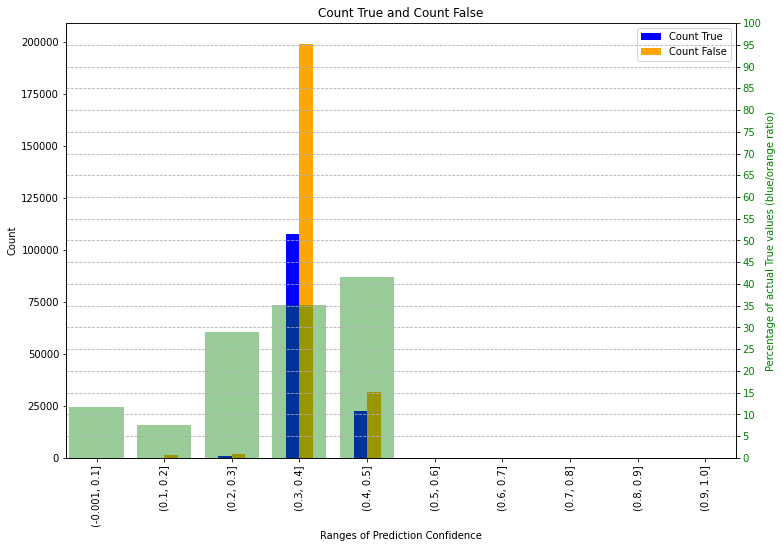

In [22]:
import matplotlib.pyplot as plt

df_predictions = pd.DataFrame(y_prediction_probabilities, columns=['predictions'])
df_results = pd.DataFrame(y_test, columns=['results'])
df_plot = pd.concat(
    [df_predictions, df_results],
    axis='columns')

# Grouping by ranges of 0.1 for numeric values and calculating percentage of True
ranges = pd.cut(df_plot['predictions'], bins=[i/10 for i in range(11)], include_lowest=True)
grouped = df_plot.groupby(ranges)['results']
percentage_true = grouped.mean() * 100  # Calculating mean as percentage
count_true = grouped.sum()
count_false = grouped.count() - count_true 

data = pd.DataFrame({'Count True': count_true, 'Count False': count_false})

fig, ax1 = plt.subplots(figsize=(12, 8))

# Creating bars for Count True and Count False
data.plot(kind='bar', width=0.4, ax=ax1, color=['blue', 'orange'])
ax1.set_ylabel('Count')
ax1.set_xlabel('Ranges of Prediction Confidence')
ax1.set_title('Count True and Count False')

ax2 = ax1.twinx()

ax2.bar(percentage_true.index.astype(str), percentage_true, color='green', alpha=0.4, label='Percentage of True')
ax2.set_ylabel('Percentage of actual True values (blue/orange ratio)', color='green')
ax2.set_xlabel('Ranges of Prediction Confidence')
ax2.grid(axis='y', linestyle='--')
ax2.yaxis.get_major_locator().set_params(nbins=20)
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 100)

plt.show()